Train a deep MLP on the MNIST dataset (you can load it using keras.datasets.mnist.load_data(). See if you can get over 98% precision. Try searching for the optimal learning rate by using the approach presented in this chapter (i.e., by growing the learning rate exponentially, plotting the loss, and finding the point where the loss shoots up). Try adding all the bells and whistles—save checkpoints, use early stopping, and plot learning curves using TensorBoard.

In [1]:
import tensorflow as tf

In [2]:
# download data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() 

In [6]:
x_train.shape # 60000 obs, 28x28
# Pixel values range from 0 to 255.
# y - 10 classes

(60000, 28, 28)

In [3]:
# create validation set and scale the data
x_valid, x_train = x_train[:5000] /255., x_train[5000:] /255.
y_valid, y_train = y_train[:5000], y_train[5000:]
x_test = x_test / 255.

In [18]:
# info about the shape of data
def shape_info(sets=["x_train","x_valid","x_test","y_train","y_valid","y_test"]):
    for set in sets:
        print(f"{set}'s shape: {eval(set).shape}")

shape_info()

x_train's shape: (55000, 28, 28)
x_valid's shape: (5000, 28, 28)
x_test's shape: (10000, 28, 28)
y_train's shape: (55000,)
y_valid's shape: (5000,)
y_test's shape: (10000,)


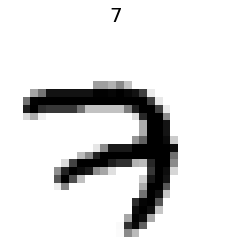

In [10]:
import matplotlib.pyplot as plt

def plot_image(idx, fsize=12):
    plt.imshow(x_train[idx], cmap = 'binary')
    plt.title(y_train[idx], fontsize=fsize)
    plt.axis('off')

plot_image(0, fsize=20)
plt.show()

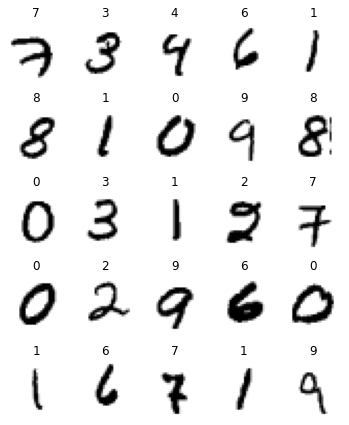

In [29]:
def plot_many_images(n_rows, n_cols):
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.5))
    for row in range(n_rows):
        for col in range(n_cols):
            idx = row * n_cols + col
            # indexes from 0 to n_cols * n_rows -1
            plt.subplot(n_rows, n_cols, idx + 1)
            # position of subplot
            plot_image(idx=idx)

plot_many_images(5,5)
plt.show()

In [6]:
# neural network
from keras.layers import Flatten, Dense

def model_mnist(n_hidden, n_neurons, l_rate=3e-3):
    model = tf.keras.models.Sequential()
    model.add(Flatten(input_shape=[28,28]))
    for i in range(n_hidden):
        model.add(Dense(n_neurons, "relu"))
    model.add(Dense(10, "softmax"))
    model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=l_rate),
              metrics=["accuracy"])
    return model

In [5]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(model_mnist)

param_distribs = {
    "n_hidden": [1, 2, 3],
    "n_neurons": np.arange(50, 300, 50).tolist()
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, cv=3, verbose=2)
rnd_search_cv.fit(x_train, y_train, epochs=100,
                  validation_data=(x_valid, y_valid),
                  callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

<ipython-input-5-4626067c1963>:4: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(model_mnist)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
1146/1146 [==============================] - 60s 52ms/step - loss: 2.0394 - accuracy: 0.3297 - val_loss: 1.6917 - val_accuracy: 0.5990
Epoch 2/100
1146/1146 [==============================] - 5s 5ms/step - loss: 1.4163 - accuracy: 0.6987 - val_loss: 1.1528 - val_accuracy: 0.7648
Epoch 3/100
1146/1146 [==============================] - 3s 2ms/step - loss: 1.0136 - accuracy: 0.7899 - val_loss: 0.8693 - val_accuracy: 0.8156
Epoch 4/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.8046 - accuracy: 0.8230 - val_loss: 0.7183 - val_accuracy: 0.8388
Epoch 5/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.6860 - accuracy: 0.8415 - val_loss: 0.6261 - val_accuracy: 0.8564
Epoch 6/100
1146/1146 [==============================] - 2s 2ms/step - loss: 0.6105 - accuracy: 0.8540 - val_loss: 0.5649 - val_accuracy: 0.8648
Epoch 7/100
1146/1146 [==============================] - 2s 2ms/ste

KeyboardInterrupt: 

In [6]:
# let's search for the optimal learning rate 
# callback will update the learning rate and record losses for each lr
K = tf.keras.backend

#callback class:
class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        # learning rate will be updated by the factor:
        self.factor = factor
        # we want to store rates and losses:
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        # learning rate will be updated for every batch
        # rates and losses:
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        # update:
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor) 

In [7]:
model.compile(loss="sparse_categorical_crossentropy", #we're predicting more than 2 classes
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3), # initial lr
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005) # we're updating lr by 0.5%

In [8]:
# now we'll be ti=uning the learning rate
# let's train model for 1 epoch and use callbacks
history = model.fit(x_train, y_train, epochs=1,
                    validation_data=(x_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 23s 12ms/step - loss: 1.4048 - accuracy: 0.6087 - val_loss: 2.2585 - val_accuracy: 0.1794


In [30]:
import numpy as np
idx = np.argmin(expon_lr.losses)
expon_lr.rates[idx]

0.5806201

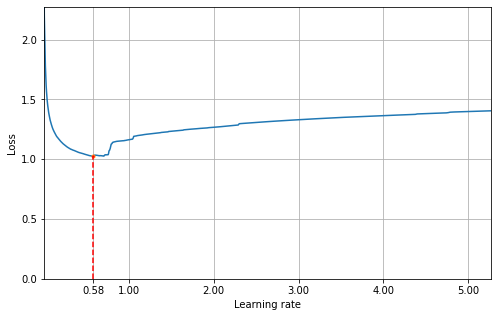

In [44]:
# plot learning rate
plt.figure(figsize=(8,5))
plt.plot(expon_lr.rates, expon_lr.losses)
plt.plot(expon_lr.rates[idx], expon_lr.losses[idx], marker='.' ,markerfacecolor='red')
plt.plot([expon_lr.rates[idx],expon_lr.rates[idx]],[0, expon_lr.losses[idx]], 'r--')
plt.xticks(list(plt.xticks()[0])+[expon_lr.rates[idx]])
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.grid()

# loss starts to grow around lr = 0.6
# rule of thumb is to use half of that rate - 0.3

In [45]:
tf.keras.backend.clear_session()
model = model_mnist(2, 300) # model with 2 hidden layers with 300 neurons each
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=3e-1),
              metrics=["accuracy"])